# Random forests and collaborative filtering on bitcoin 
## Bitcoin data revisited 

The goal of this notebook is to use Latent Dirichlet Allocation as a collaborative filtering algorithm on bitcoin data. 

In [ ]:
# import data from septembre of 2022 since it was rather stable during this period
import pandas as pd

# data are 15 minute candlesticks
df = pd.read_csv("btc-data/BTCUSDT_15_2023-09-01_2023-09-30.csv", names=["time","open","high","low","close","vol"], header=None)

# if on kaggle:
# df = pd.read_csv("/kaggle/input/btcusdt-15-2023-09-01-2023-09-30/BTCUSDT_15_2023-09-01_2023-09-30.csv", names=["time","open","high","low","close","vol"], header=None)

print(df.shape)
df.head(3)

**Now we want to recreate this blog post:** <br/>
https://towardsdatascience.com/create-a-recommendation-system-based-on-time-series-data-using-latent-dirichlet-allocation-2aa141b99e19

To do this, we need to think about our data a bit different: 
In the blog post LDA has been used to get groups of different people who watch shows with a certain probability during a 24 hour period. 

Therefore it is necessary to ask a different question about the data: During which hour of the day is what variation the most likely? 

The next step is therefore to calculate normalized differences of the day starting with the open price. 

In [50]:
# transform to date_time
df["time"] = pd.to_datetime(df["time"])

# Extracting day and hour
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour
df.head(3)

,time,open,high,low,close,vol,day,hour
0,2023-09-01 00:00:00,26009.3,26016.5,25627.2,25856.8,20063.967,1,0
1,2023-09-01 00:15:00,25856.8,26021.2,25840.1,25910.7,5158.731,1,0
2,2023-09-01 00:30:00,25910.7,25955.9,25888.7,25945.7,1300.917,1,0


In [51]:
# group the open prices by day and then use the function "first" on the groups
df["daily_open"] = df.groupby(df["day"])["open"].transform("first")
print(df.shape)
df.head(3)

(2881, 9)


,time,open,high,low,close,vol,day,hour,daily_open
0,2023-09-01 00:00:00,26009.3,26016.5,25627.2,25856.8,20063.967,1,0,26009.3
1,2023-09-01 00:15:00,25856.8,26021.2,25840.1,25910.7,5158.731,1,0,26009.3
2,2023-09-01 00:30:00,25910.7,25955.9,25888.7,25945.7,1300.917,1,0,26009.3


In [52]:
# deviation of close prices given the open price in percent of deviation
df["perc_dev"] = abs(((df["daily_open"]-df["close"])/df["daily_open"])*100)
print(df.shape)
df[1200:1300].head(3)

(2881, 10)


,time,open,high,low,close,vol,day,hour,daily_open,perc_dev
1200,2023-09-13 12:00:00,25938.9,25939.0,25910.8,25923.8,454.151,13,12,26060.4,0.524167
1201,2023-09-13 12:15:00,25923.8,26045.0,25912.5,26010.5,3693.605,13,12,26060.4,0.191478
1202,2023-09-13 12:30:00,26010.5,26133.9,25985.7,26066.4,3959.197,13,12,26060.4,0.023023


<Axes: xlabel='hour'>

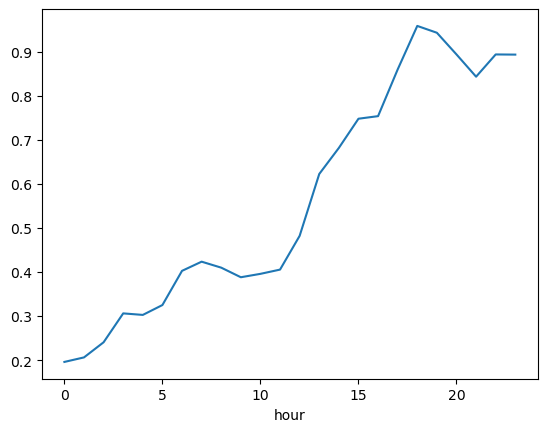

In [67]:
df["perc_dev"].groupby(df["hour"]).mean().plot()
#df["perc_dev"].groupby(df["hour"]).std().plot()

# > standard deviation goes by construction up, since the price is deviating the further it is away from the open price

In [54]:
# index is grouping by day, since a day has 24 hours and the values are spread along 30 days to 24 hours 
df_pivot = pd.pivot_table(df,index="day",columns="hour",values="perc_dev")

print(df_pivot.shape)
df_pivot.tail(3)

(30, 24)


hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
28,0.090961,0.241833,0.319173,0.792075,0.639680,0.538242,0.412230,0.533384,0.748643,0.673397,...,0.835984,0.897228,1.024098,1.659015,2.498428,3.286218,3.332794,3.123917,3.056005,3.228784
29,0.308772,0.254832,0.165516,0.098183,0.158958,0.449165,0.581060,0.473457,0.427644,0.291130,...,0.314037,0.408987,0.425427,0.764218,0.809753,0.838755,0.824069,0.867573,0.561387,0.628443
30,0.073511,0.086243,0.027602,0.054460,0.036152,0.042750,0.018308,0.054739,0.087823,0.090890,...,0.156874,0.090983,0.102879,0.289956,0.393300,0.370903,0.376943,0.357241,0.373319,0.513836


In [74]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=3).fit(df_pivot)

In [75]:
#Create the hour-cluster / term-topic matrix
df_comp = pd.DataFrame(lda.components_.T, index=df_pivot.columns) #Normalize it 

norm_components = lda.components_/lda.components_.sum(axis=1).reshape(-1, 1)

df_comp_norm = pd.DataFrame(norm_components.T, index=df_pivot.columns)
df_comp_norm * 100

,0,1,2
hour,,,
0,0.743522,10.557821,4.531699
1,0.803630,2.805481,6.957594
2,0.730818,3.343134,9.139147
3,1.262579,2.634150,9.392180
4,1.290181,2.674873,9.018608
5,1.404776,2.761754,9.458567
6,2.268940,2.623456,8.072308
7,2.505883,2.626369,7.658320
8,2.391713,2.528992,7.691151


To summarise, it seems that there is too little data to have a meaningful clustering of deviation based on the opening price. In essence, there was only one month. Another approach would be to use more finegraiend data, like a 1m data or more month. 